# Baseline Models for Theme Park Wait Time Prediction

This script implements various baseline models to compare with the Prophet model for
predicting wait times at theme park attractions.

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define consistent colors for plots
TRAIN_COLOR = 'steelblue'
TRAIN_FILL_COLOR = 'steelblue'
TRAIN_FILL_ALPHA = 0.3
VAL_COLOR = 'coral'
VAL_FILL_COLOR = 'coral'
VAL_FILL_ALPHA = 0.3

## Data Loading and Initial Preprocessing

We'll use the same preprocessing as the Prophet model for consistency.

In [92]:
def load_ride_data(file_path, ride_name):
    """Load data for a specific ride and perform initial preprocessing."""
    full_data = pd.read_parquet(file_path)
    
    # Filter for the specified ride
    ride_data = full_data.loc[full_data["ride_name"] == ride_name].reset_index(drop=True)
    ride_data.loc[:, "closed"] = ride_data["closed"].astype(bool).astype(int)
    
    # Resample to 30-minute intervals
    ride_data = ride_data.set_index("timestamp").resample("30min").ffill().reset_index()
    
    # Remove off-season data (January-March)
    ride_data = ride_data.loc[ride_data["timestamp"].dt.month > 3].reset_index(drop=True)
    
    return ride_data

In [93]:
def remove_closed_and_zero_wait_days(ride_data):
    """Remove days when the ride was fully closed or had no recorded wait times."""
    # Identify and remove fully closed days
    daily_closure_status = ride_data.groupby(ride_data["timestamp"].dt.date)["closed"].mean()
    fully_closed_days = daily_closure_status[daily_closure_status == 1].index
    
    print(f"Number of fully closed days: {len(fully_closed_days)}")
    print("Sample of fully closed days:", fully_closed_days[:10])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(fully_closed_days)]
    
    # Identify and remove days with zero wait times
    daily_wait_times = ride_data.groupby(ride_data["timestamp"].dt.date)["wait_time"].mean()
    zero_wait_days = daily_wait_times[daily_wait_times < 1].index
    
    print(f"Number of days with zero wait times: {len(zero_wait_days)}")
    print("Sample of zero wait time days:", zero_wait_days[:10])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(zero_wait_days)]
    
    return ride_data

In [94]:
def filter_to_operating_hours(ride_data):
    """Keep only data during ride operating hours."""
    # Determine operating hours from data where wait times > 0
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()
    
    # Extract opening and closing hours
    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour
    
    # Set reasonable boundaries for operating hours
    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)
    
    # Create date-to-hours mapping
    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])
    
    # Filter data to operating hours only
    def is_operating_hour(timestamp):
        date = timestamp.date()
        if date not in date_to_hours:
            # Handle dates not found in mapping
            return 0
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data

In [95]:
# Load data
input_file = "../data/processed/ep/merged_with_holidays.parquet"
ride_name = "silver star"

# Process ride data (same as in Prophet model)
ride_df = load_ride_data(input_file, ride_name)
print(f"Initial ride data shape: {ride_df.shape}")

# Remove closed days and days with zero wait times
ride_df = remove_closed_and_zero_wait_days(ride_df)
print(f"After removing closed/zero days: {ride_df.shape}")

# Filter to operating hours only
ride_df = filter_to_operating_hours(ride_df)
print(f"After filtering to operating hours: {ride_df.shape}")

Initial ride data shape: (103081, 10)
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 82
Sample of zero wait time days: Index([2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30,
       2017-12-01, 2017-12-02, 2017-12-03, 2017-12-04],
      dtype='object', name='timestamp')
After removing closed/zero days: (85561, 10)
After filtering to operating hours: (30240, 10)


## Feature Engineering for Baseline Models

We'll prepare the data in the same way as for Prophet to ensure fair comparison.

In [96]:
def prepare_data_for_baseline(ride_data):
    """Transform data into a consistent format for all models."""
    # Select relevant columns and rename 
    baseline_data = ride_data[["timestamp", "wait_time", "closed", "temperature", "rain"]].copy()
    baseline_data = baseline_data.rename(columns={"timestamp": "ds", "wait_time": "y"})
    
    # Set weather to 0 when ride is closed
    baseline_data.loc[baseline_data["closed"] == 1, "temperature"] = 0
    baseline_data.loc[baseline_data["closed"] == 1, "rain"] = 0
    
    # Fill missing values
    baseline_data["temperature"] = baseline_data["temperature"].ffill()
    baseline_data["rain"] = baseline_data["rain"].ffill()
    
    # Add transformed variables and interaction terms (same as Prophet)
    baseline_data['temp_squared'] = baseline_data['temperature'] ** 2
    baseline_data['high_temp'] = (baseline_data['temperature'] > 25).astype(int)
    baseline_data['any_rain'] = (baseline_data['rain'] > 0).astype(int)
    baseline_data['is_weekend'] = baseline_data['ds'].dt.dayofweek.isin([5, 6]).astype(int)
    baseline_data['temp_weekend'] = baseline_data['temperature'] * baseline_data['is_weekend']
    baseline_data['rain_weekend'] = baseline_data['rain'] * baseline_data['is_weekend']
    
    # Add time features useful for baseline models
    baseline_data['hour'] = baseline_data['ds'].dt.hour
    baseline_data['minute'] = baseline_data['ds'].dt.minute
    baseline_data['time_key'] = baseline_data['hour'] * 60 + baseline_data['minute']
    baseline_data['day_of_week'] = baseline_data['ds'].dt.dayofweek
    baseline_data['month'] = baseline_data['ds'].dt.month
    
    return baseline_data

# Create baseline-ready dataframe with feature engineering
baseline_df = prepare_data_for_baseline(ride_df)
print(f"Prepared data shape: {baseline_df.shape}")
print(f"Columns: {baseline_df.columns.tolist()}")

# Display sample of prepared data
baseline_df.head()

Prepared data shape: (30240, 16)
Columns: ['ds', 'y', 'closed', 'temperature', 'rain', 'temp_squared', 'high_temp', 'any_rain', 'is_weekend', 'temp_weekend', 'rain_weekend', 'hour', 'minute', 'time_key', 'day_of_week', 'month']


,ds,y,closed,temperature,rain,temp_squared,high_temp,any_rain,is_weekend,temp_weekend,rain_weekend,hour,minute,time_key,day_of_week,month
0,2017-05-23 09:00:00,0.0,0,18.7,0.0,349.69,0,0,0,0.0,0.0,9,0,540,1,5
1,2017-05-23 09:30:00,10.0,0,18.7,0.0,349.69,0,0,0,0.0,0.0,9,30,570,1,5
2,2017-05-23 10:00:00,10.0,0,21.5,0.0,462.25,0,0,0,0.0,0.0,10,0,600,1,5
3,2017-05-23 10:30:00,25.0,0,21.5,0.0,462.25,0,0,0,0.0,0.0,10,30,630,1,5
4,2017-05-23 11:00:00,15.0,0,23.8,0.0,566.44,0,0,0,0.0,0.0,11,0,660,1,5


## Holiday Effects

We'll create the holiday dataframes.

In [97]:
def create_holiday_dataframes(ride_data):
    """Create holiday dataframes for models."""
    holiday_dfs = []
    
    # Process country holidays
    for country in ['swiss', 'german', 'french']:
        holiday_col = f"is_{country}_holiday"
        if holiday_col in ride_data.columns:
            country_holidays = ride_data.loc[ride_data[holiday_col] == 1, ["timestamp"]]
            if len(country_holidays) > 0:
                country_holidays["ds"] = pd.to_datetime(country_holidays["timestamp"]).dt.date
                country_holidays = country_holidays.drop_duplicates(subset=["ds"])
                country_holidays = country_holidays.drop(columns=["timestamp"])
                country_holidays["holiday"] = f"{country}_holiday"
                country_holidays["lower_window"] = 0
                country_holidays["upper_window"] = 0
                holiday_dfs.append(country_holidays.reset_index(drop=True))
    
    # Add COVID periods
    covid_era = pd.DataFrame({
        'holiday': 'covid_era',
        'ds': pd.date_range(start='2020-04-15', end='2020-05-20'),
        'lower_window': 0,
        'upper_window': 0
    })
    
    covid_recovery = pd.DataFrame({
        'holiday': 'covid_recovery',
        'ds': pd.date_range(start='2021-05-21', end='2021-07-31'),
        'lower_window': 0,
        'upper_window': 0
    })
    
    holiday_dfs.extend([covid_era, covid_recovery])
    
    # Combine all holidays
    all_holidays = pd.concat(holiday_dfs)
    all_holidays["ds"] = pd.to_datetime(all_holidays["ds"])
    
    return all_holidays.sort_values(by=["ds"]).reset_index(drop=True)

# Create holiday dataframes
holidays_df = create_holiday_dataframes(ride_df)
print(f"Created holiday dataframe with {len(holidays_df)} entries")
holidays_df.head()

Created holiday dataframe with 306 entries


,ds,holiday,lower_window,upper_window
0,2017-05-25,swiss_holiday,0,0
1,2017-05-25,french_holiday,0,0
2,2017-05-25,german_holiday,0,0
3,2017-05-27,french_holiday,0,0
4,2017-06-05,german_holiday,0,0


## Train-Test Split

We'll use the same train-test split as in the Prophet model (pre-2023 vs 2023).

In [98]:
# Sort data chronologically
baseline_df = baseline_df.sort_values(by="ds")

# Split into training and validation sets (same as Prophet)
train_df = baseline_df.loc[(baseline_df["ds"] < "2023-01-01")].reset_index(drop=True)
val_df = baseline_df.loc[(baseline_df["ds"] >= "2023-01-01") & 
                        (baseline_df["ds"] < "2024-01-01")].reset_index(drop=True)

print(f"Training data: {train_df.shape[0]} rows from {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"Validation data: {val_df.shape[0]} rows from {val_df['ds'].min()} to {val_df['ds'].max()}")

Training data: 22104 rows from 2017-05-23 09:00:00 to 2022-12-31 17:30:00
Validation data: 4184 rows from 2023-04-01 09:00:00 to 2023-12-31 16:30:00


## Helper Functions for Evaluation and Visualization

We'll use the same functions for evaluation and visualization as in the Prophet model.

In [99]:
def combine_forecast_with_actual(forecast, train_data, val_data):
    """Combine forecast with actual data for visualization."""
    forecast.index = pd.to_datetime(forecast.ds)
    
    train_data.index = pd.to_datetime(train_data.ds)
    val_data.index = pd.to_datetime(val_data.ds)
    
    data = pd.concat([train_data, val_data], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

def post_process_forecast(forecast, closed_data):
    """Apply corrections to forecasted values."""
    # Set predictions to zero during known closures
    closed_mask = forecast['ds'].isin(closed_data.loc[closed_data['closed'] == 1, 'ds'])
    forecast.loc[closed_mask, 'yhat'] = 0
    forecast.loc[closed_mask, 'yhat_lower'] = 0
    forecast.loc[closed_mask, 'yhat_upper'] = 0
    
    # Correct negative predictions
    negative_mask = forecast['yhat'] < 0
    forecast.loc[negative_mask, 'yhat'] = 0
    forecast.loc[negative_mask, 'yhat_lower'] = 0
    forecast.loc[negative_mask, 'yhat_upper'] = 0
    
    return forecast

def plot_forecast_comparison(forecast_data, split_year, show_uncertainty=True, model_name="Model"):
    """Plot forecasts against actual data with training/validation split."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Training period
    train = forecast_data.loc[:str(split_year - 1),:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color=TRAIN_COLOR, lw=0.5)
    if show_uncertainty:
        ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, 
                        color=TRAIN_FILL_COLOR, alpha=TRAIN_FILL_ALPHA)
    
    # Validation period
    val = forecast_data.loc[str(split_year):,:]
    ax.plot(val.index, val.y, 'ro', markersize=3)
    ax.plot(val.index, val.yhat, color=VAL_COLOR, lw=0.5)
    if show_uncertainty:
        ax.fill_between(val.index, val.yhat_lower, val.yhat_upper, 
                        color=VAL_FILL_COLOR, alpha=VAL_FILL_ALPHA)
        
    # Add year divider
    ax.axvline(pd.Timestamp(f'{split_year}-01-01'), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=6, label='Training Actual'),
        Line2D([0], [0], color=TRAIN_COLOR, lw=2, label='Training Forecast'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=6, label='Validation Actual'),
        Line2D([0], [0], color=VAL_COLOR, lw=2, label='Validation Forecast')
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_title(f'{model_name} Wait Time Forecast: Training vs Validation (Split at {split_year})', fontsize=14)
    ax.set_ylabel('Wait Time (minutes)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    return fig

def plot_time_period(forecast_data, start_date, end_date, ax=None, show_uncertainty=True, model_name="Model"):
    """Plot forecast vs actual for a specific time period."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        
    df = forecast_data.loc[start_date:end_date,:]

    df.loc[:,'yhat'].plot(lw=2, ax=ax, color=VAL_COLOR, ls='-', label='Forecast')

    if show_uncertainty:
        ax.fill_between(df.index, df.loc[:,'yhat_lower'], df.loc[:,'yhat_upper'], 
                        color=VAL_FILL_COLOR, alpha=VAL_FILL_ALPHA)
    df.loc[:,'y'].plot(lw=2, ax=ax, color=TRAIN_COLOR, ls='-', label='Actual')

    ax.grid(ls=':')
    ax.legend(fontsize=15)
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    ax.set_ylabel('Wait time (minutes)', fontsize=15)
    ax.set_xlabel('', fontsize=15)

    start_date_weekday = pd.Timestamp(start_date).day_name()
    end_date_weekday = pd.Timestamp(end_date).day_name()
    ax.set_title(f'{model_name}: {start_date} ({start_date_weekday}) to {end_date} ({end_date_weekday})', fontsize=18)
    
    return ax

def calculate_error_metrics(forecast, val_data):
    """Calculate and display error metrics for model evaluation."""
    # Filter forecast to validation period
    val_forecast = forecast[forecast['ds'].isin(val_data['ds'])].fillna(0)
    
    # Calculate metrics
    mae = mean_absolute_error(val_forecast["y"], val_forecast["yhat"])
    mse = mean_squared_error(val_forecast['y'], val_forecast['yhat'])
    rmse = np.sqrt(mse)
    
    # Standard MAPE calculation - handle zeros with epsilon to avoid division by zero
    epsilon = 1e-8
    abs_pct_errors = np.abs(val_forecast['y'] - val_forecast['yhat']) / (np.abs(val_forecast['y']) + epsilon)
    # Only include points where actual values are non-zero
    non_zero_mask = val_forecast['y'] > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    
    within_ci = ((val_forecast['y'] >= val_forecast['yhat_lower']) & 
                 (val_forecast['y'] <= val_forecast['yhat_upper'])).mean() * 100
    
    print(f"MAE (Mean Absolute Error): {mae:.2f} minutes")
    print(f"RMSE (Root-Mean-Square Deviation): {rmse:.2f} minutes")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"Percentage of predictions within confidence interval: {within_ci:.2f}%")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'within_ci': within_ci}

## Baseline Model 1: Mean Baseline

This is the simplest baseline, predicting the mean value of the training data.

---- Training Mean Baseline Model ----


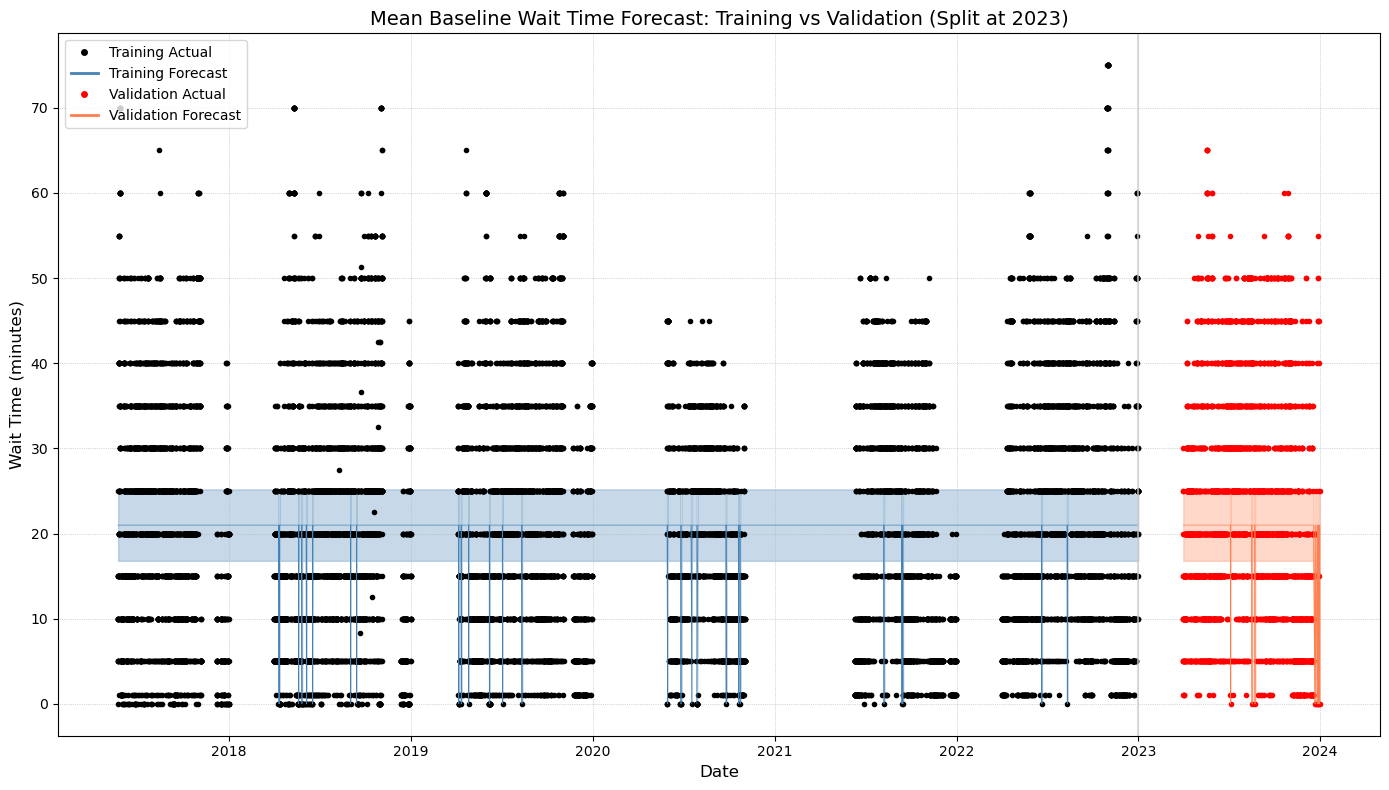


Mean Baseline Model Evaluation:
MAE (Mean Absolute Error): 10.94 minutes
RMSE (Root-Mean-Square Deviation): 13.64 minutes
MAPE (Mean Absolute Percentage Error): 114.07%
Percentage of predictions within confidence interval: 28.13%


In [100]:
class MeanBaselineModel:
    """A simple baseline model that predicts the mean value of the training data."""
    def __init__(self):
        self.mean_value = None
        
    def fit(self, train_data):
        """Fit the model by calculating the mean of the training data"""
        self.mean_value = train_data['y'].mean()
        return self
        
    def predict(self, future_df):
        """Predict using the mean value for all future points"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        predictions['yhat'] = self.mean_value
        predictions['yhat_lower'] = self.mean_value * 0.8  # Simple confidence interval
        predictions['yhat_upper'] = self.mean_value * 1.2
        return predictions

# Create future dataframe for predictions
future = pd.DataFrame({'ds': pd.concat([train_df['ds'], val_df['ds']]).unique()})
future = future.sort_values('ds').reset_index(drop=True)

# Train and evaluate the Mean Baseline model
print("---- Training Mean Baseline Model ----")
mean_model = MeanBaselineModel()
mean_model.fit(train_df)
mean_forecast = mean_model.predict(future)
mean_forecast = post_process_forecast(mean_forecast, baseline_df)
mean_combined = combine_forecast_with_actual(mean_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(mean_combined, split_year=2023, show_uncertainty=True, model_name="Mean Baseline")
plt.tight_layout()
plt.savefig("mean_baseline_forecast.png")
plt.show()

# Calculate error metrics
print("\nMean Baseline Model Evaluation:")
mean_metrics = calculate_error_metrics(mean_combined, val_df)

## Baseline Model 2: Time-of-Day Baseline

This model captures daily patterns by using the average wait time for each time of day based on training data.


---- Training Time-of-Day Baseline Model ----


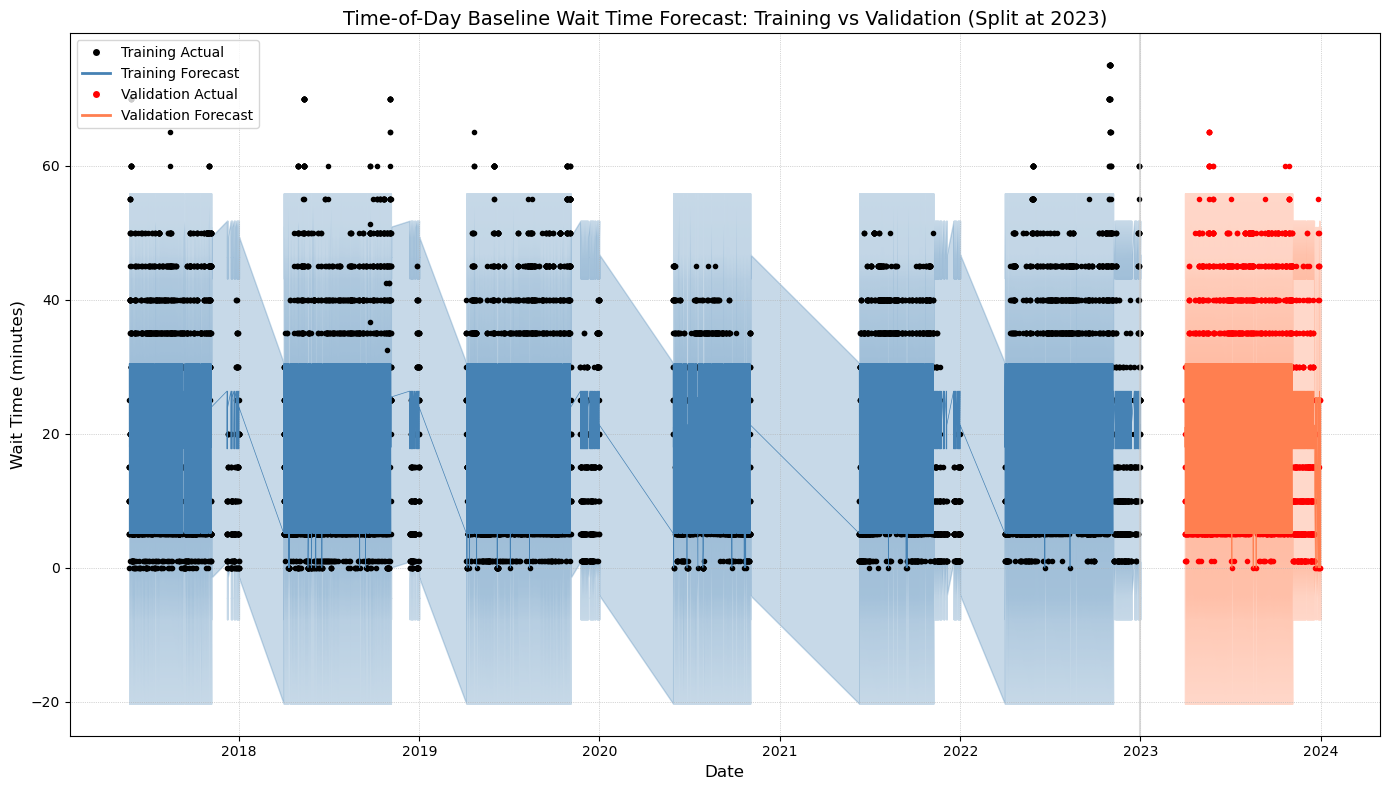


Time-of-Day Baseline Model Evaluation:
MAE (Mean Absolute Error): 9.92 minutes
RMSE (Root-Mean-Square Deviation): 12.73 minutes
MAPE (Mean Absolute Percentage Error): 94.82%
Percentage of predictions within confidence interval: 95.08%


In [101]:
class TimeOfDayBaselineModel:
    """A baseline model that uses patterns at different times of day."""
    def __init__(self):
        self.time_of_day_means = None
        self.global_mean = None
        
    def fit(self, train_data):
        """Fit the model by calculating mean values for each time of day"""
        # Calculate mean for each time of day
        self.time_of_day_means = train_data.groupby('time_key')['y'].mean().to_dict()
        self.global_mean = train_data['y'].mean()  # Fallback value
        return self
        
    def predict(self, future_df):
        """Predict using time-of-day pattern"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        
        # Extract hour and minute from prediction dates
        predictions['hour'] = predictions['ds'].dt.hour
        predictions['minute'] = predictions['ds'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        
        # Assign predictions based on time of day
        predictions['yhat'] = predictions['time_key'].map(
            lambda x: self.time_of_day_means.get(x, self.global_mean))
        
        # Simple confidence interval
        std_dev = train_df['y'].std()
        predictions['yhat_lower'] = predictions['yhat'] - 1.96 * std_dev
        predictions['yhat_upper'] = predictions['yhat'] + 1.96 * std_dev
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Train and evaluate the Time-of-Day Baseline model
print("\n---- Training Time-of-Day Baseline Model ----")
tod_model = TimeOfDayBaselineModel()
tod_model.fit(train_df)
tod_forecast = tod_model.predict(future)
tod_forecast = post_process_forecast(tod_forecast, baseline_df)
tod_combined = combine_forecast_with_actual(tod_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(tod_combined, split_year=2023, show_uncertainty=True, model_name="Time-of-Day Baseline")
plt.tight_layout()
plt.savefig("time_of_day_baseline_forecast.png")
plt.show()

# Calculate error metrics
print("\nTime-of-Day Baseline Model Evaluation:")
tod_metrics = calculate_error_metrics(tod_combined, val_df)

## Baseline Model 3: Day-of-Week + Time-of-Day Baseline

This model combines day of week patterns with time of day patterns for more accurate predictions.


---- Training Day-of-Week + Time-of-Day Baseline Model ----


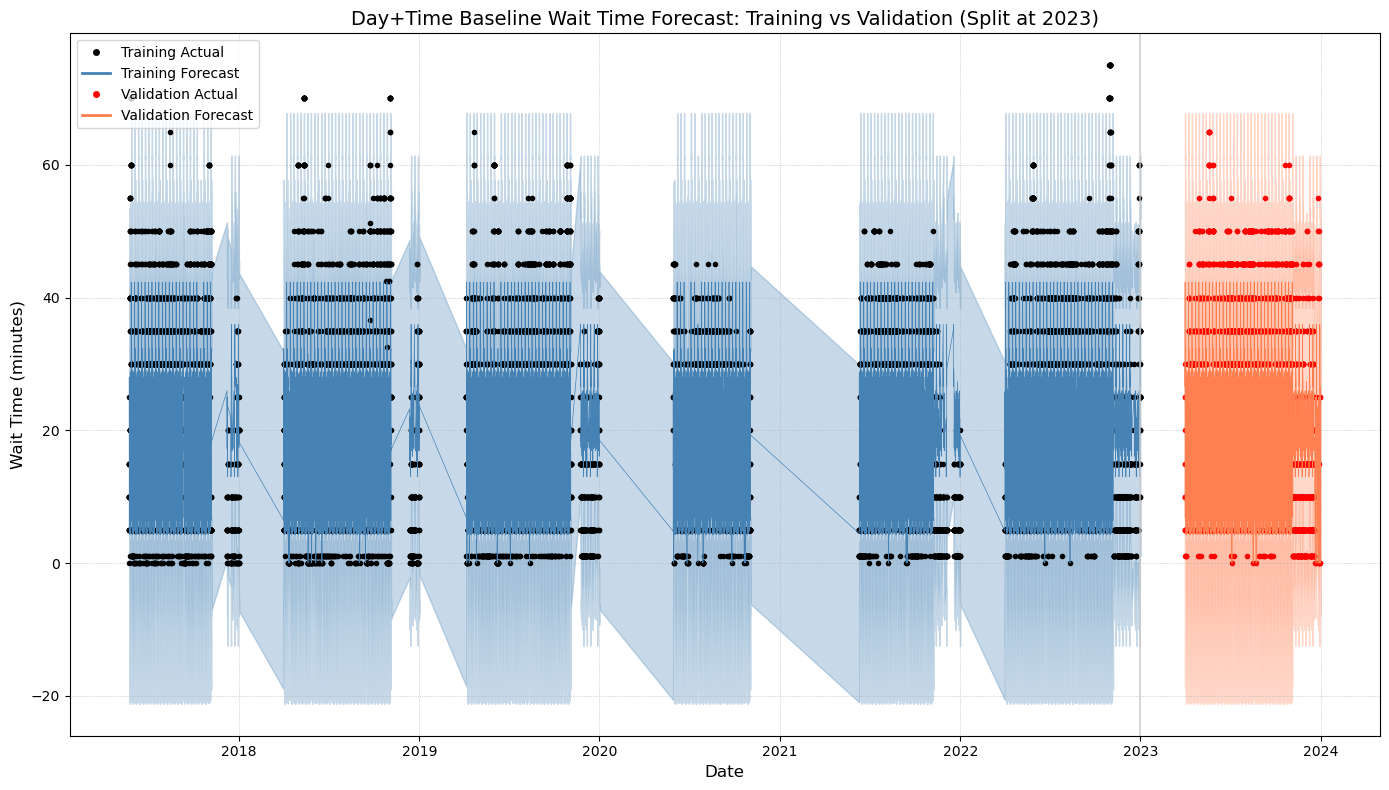


Day+Time Baseline Model Evaluation:
MAE (Mean Absolute Error): 9.02 minutes
RMSE (Root-Mean-Square Deviation): 11.94 minutes
MAPE (Mean Absolute Percentage Error): 85.40%
Percentage of predictions within confidence interval: 95.32%


In [102]:
class DayAndTimeBaselineModel:
    """A model that combines day of week patterns with time of day patterns."""
    def __init__(self):
        self.day_time_means = None
        self.time_means = None
        self.global_mean = None
        
    def fit(self, train_data):
        """Fit the model by calculating mean values for each day+time combination"""
        # Calculate mean for each day and time combination
        train_data['day_time_key'] = (train_data['day_of_week'] * 24 * 60 + 
                                      train_data['time_key'])
        
        self.day_time_means = train_data.groupby('day_time_key')['y'].mean().to_dict()
        self.time_means = train_data.groupby('time_key')['y'].mean().to_dict()
        self.global_mean = train_data['y'].mean()
        self.std_dev = train_data['y'].std()
        
        return self
        
    def predict(self, future_df):
        """Predict using day-of-week and time-of-day patterns"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        
        # Extract day of week, hour and minute
        predictions['day_of_week'] = predictions['ds'].dt.dayofweek
        predictions['hour'] = predictions['ds'].dt.hour
        predictions['minute'] = predictions['ds'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        predictions['day_time_key'] = (predictions['day_of_week'] * 24 * 60 + 
                                      predictions['time_key'])
        
        # First try to find day+time combination
        predictions['yhat'] = predictions['day_time_key'].map(
            lambda x: self.day_time_means.get(x, None))
        
        # If not found, fall back to time of day
        mask = predictions['yhat'].isna()
        predictions.loc[mask, 'yhat'] = predictions.loc[mask, 'time_key'].map(
            lambda x: self.time_means.get(x, self.global_mean))
        
        # Confidence interval
        predictions['yhat_lower'] = predictions['yhat'] - 1.96 * self.std_dev
        predictions['yhat_upper'] = predictions['yhat'] + 1.96 * self.std_dev
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Train and evaluate the Day+Time Baseline model
print("\n---- Training Day-of-Week + Time-of-Day Baseline Model ----")
day_time_model = DayAndTimeBaselineModel()
day_time_model.fit(train_df)
day_time_forecast = day_time_model.predict(future)
day_time_forecast = post_process_forecast(day_time_forecast, baseline_df)
day_time_combined = combine_forecast_with_actual(day_time_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(day_time_combined, split_year=2023, show_uncertainty=True, 
                       model_name="Day+Time Baseline")
plt.tight_layout()
plt.savefig("day_time_baseline_forecast.png")
plt.show()

# Calculate error metrics
print("\nDay+Time Baseline Model Evaluation:")
day_time_metrics = calculate_error_metrics(day_time_combined, val_df)

## Baseline Model 4: Moving Average Baseline

This model uses the average of recent observations to make predictions.


---- Training Moving Average Baseline Model ----


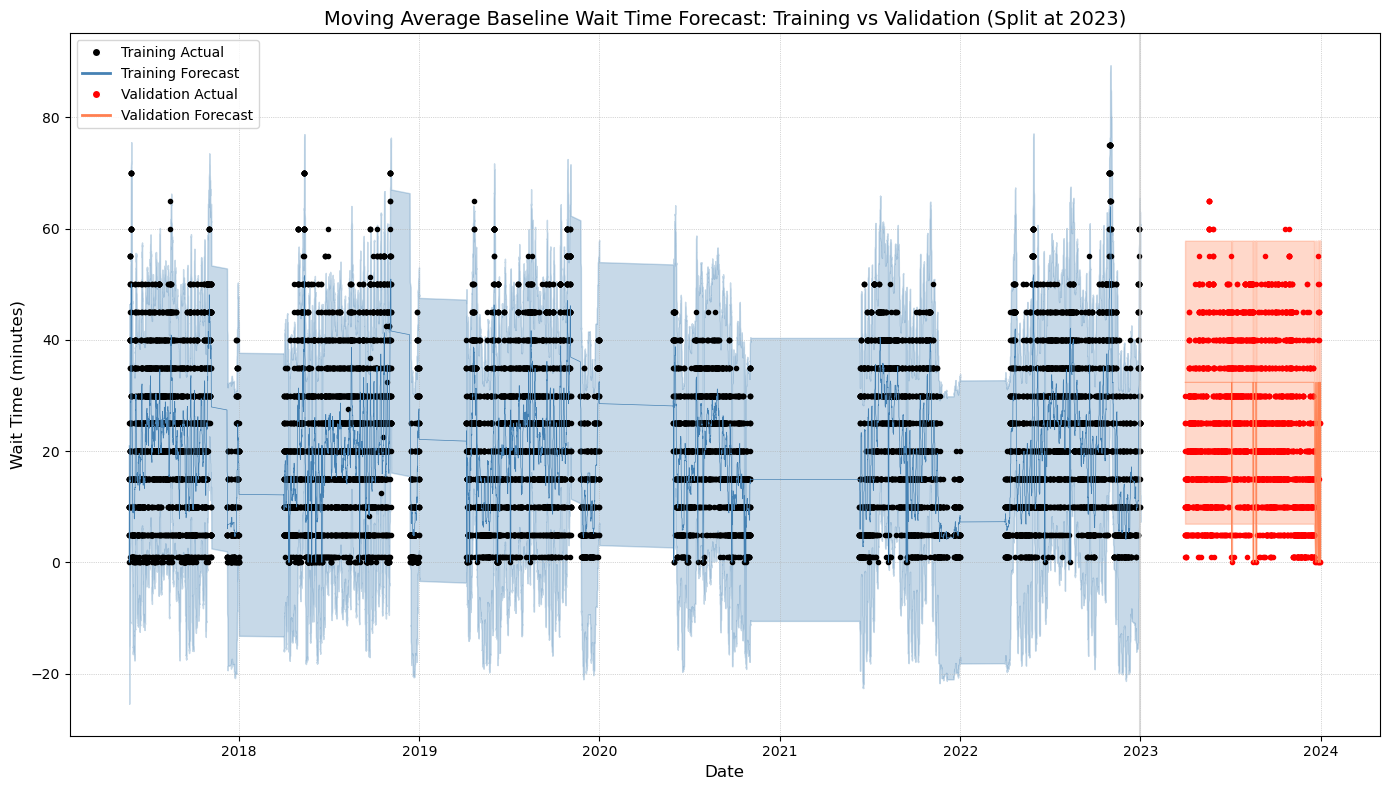


Moving Average Baseline Model Evaluation:
MAE (Mean Absolute Error): 14.73 minutes
RMSE (Root-Mean-Square Deviation): 17.07 minutes
MAPE (Mean Absolute Percentage Error): 190.60%
Percentage of predictions within confidence interval: 85.01%


In [103]:
class MovingAverageBaselineModel:
    """This model uses the average of recent observations for predictions."""
    def __init__(self, window_size=48):  # Default: 1 day (48 30-min intervals)
        self.window_size = window_size
        self.historical_data = None
        self.global_mean = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store the training data for later prediction"""
        # Make a copy and reset index to avoid ambiguity issues
        self.historical_data = train_data.copy().reset_index(drop=True)
        self.global_mean = self.historical_data['y'].mean()
        self.std_dev = self.historical_data['y'].std()
        return self
        
    def predict(self, future_df):
        """Predict using moving average of recent observations"""
        # Create a copy of future_df with reset index
        future_copy = future_df.copy().reset_index(drop=True)
        predictions = pd.DataFrame({'ds': future_copy['ds']})
        
        # Create lists for predictions and confidence intervals
        yhat = []
        yhat_lower = []
        yhat_upper = []
        
        # Sort historical data by date
        sorted_history = self.historical_data.sort_values('ds').reset_index(drop=True)
        
        # For each prediction date, calculate the moving average
        for pred_date in predictions['ds']:
            # Find recent observations (before the prediction date)
            recent_data = sorted_history[sorted_history['ds'] < pred_date].tail(self.window_size)
            
            if len(recent_data) > 0:
                # Calculate the mean of recent observations
                pred_value = recent_data['y'].mean()
            else:
                # Fallback to global mean if no recent data
                pred_value = self.global_mean
                
            # Store prediction and confidence interval
            yhat.append(pred_value)
            yhat_lower.append(pred_value - 1.96 * self.std_dev)
            yhat_upper.append(pred_value + 1.96 * self.std_dev)
        
        # Add predictions to dataframe
        predictions['yhat'] = yhat
        predictions['yhat_lower'] = yhat_lower
        predictions['yhat_upper'] = yhat_upper
        
        return predictions

# Train and evaluate the Moving Average Baseline model
print("\n---- Training Moving Average Baseline Model ----")
ma_model = MovingAverageBaselineModel(window_size=48)  # 1 day = 48 30-min intervals
ma_model.fit(train_df)
ma_forecast = ma_model.predict(future)
ma_forecast = post_process_forecast(ma_forecast, baseline_df)
ma_combined = combine_forecast_with_actual(ma_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(ma_combined, split_year=2023, show_uncertainty=True, 
                       model_name="Moving Average Baseline")
plt.tight_layout()
plt.savefig("moving_average_baseline_forecast.png")
plt.show()

# Calculate error metrics
print("\nMoving Average Baseline Model Evaluation:")
ma_metrics = calculate_error_metrics(ma_combined, val_df)

## Baseline Model 5: Seasonal Weekly Pattern Model

This model leverages weekly patterns by using data from the same day and time in previous weeks.



---- Training Seasonal Weekly Pattern Model ----


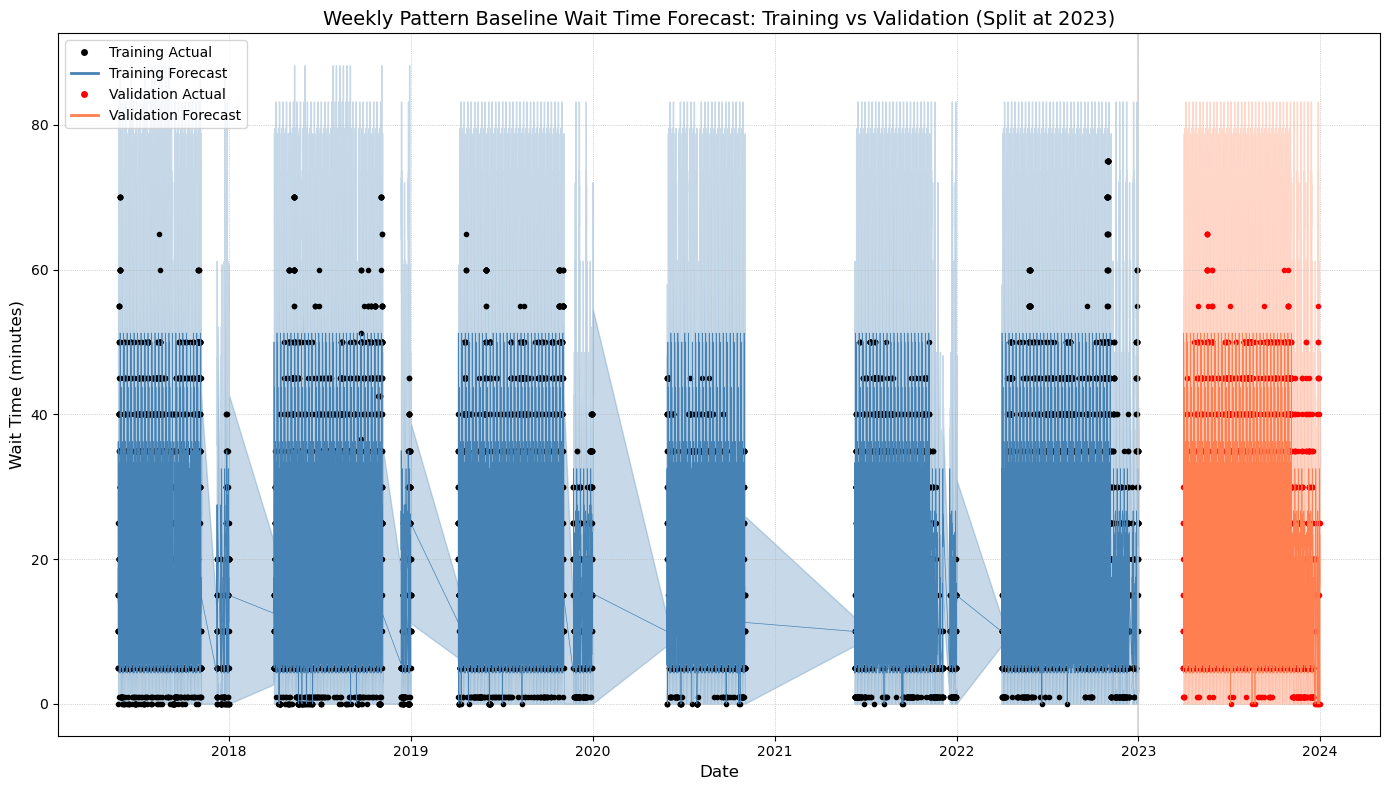


Weekly Pattern Baseline Model Evaluation:
MAE (Mean Absolute Error): 11.21 minutes
RMSE (Root-Mean-Square Deviation): 14.82 minutes
MAPE (Mean Absolute Percentage Error): 83.47%
Percentage of predictions within confidence interval: 74.59%


In [104]:
class SeasonalWeeklyBaselineModel:
    """This model uses data from the same day and time in previous weeks."""
    def __init__(self, num_weeks=4):
        self.num_weeks = num_weeks
        self.training_data = None
        self.global_mean = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store the training data for later prediction"""
        # Make a copy and reset index to avoid ambiguity issues
        self.training_data = train_data.copy().reset_index(drop=True)
        self.global_mean = self.training_data['y'].mean()
        self.std_dev = self.training_data['y'].std()
        
        # Pre-calculate time features for training data
        self.training_data['day_of_week'] = self.training_data['ds'].dt.dayofweek
        self.training_data['hour'] = self.training_data['ds'].dt.hour
        self.training_data['minute'] = self.training_data['ds'].dt.minute
        self.training_data['time_key'] = self.training_data['hour'] * 60 + self.training_data['minute']
        
        return self
        
    def predict(self, future_df):
        """Predict using the same day of week and time of day from previous weeks"""
        # Create a copy of future_df with reset index
        future_copy = future_df.copy().reset_index(drop=True)
        predictions = pd.DataFrame({'ds': future_copy['ds']})
        
        # Extract day of week and time for predictions
        predictions['day_of_week'] = predictions['ds'].dt.dayofweek
        predictions['hour'] = predictions['ds'].dt.hour
        predictions['minute'] = predictions['ds'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        
        # Predict for each point based on same day/time from previous weeks
        yhat = []
        yhat_lower = []
        yhat_upper = []
        
        for _, row in predictions.iterrows():
            # Find matching day and time in training data
            matches = self.training_data[
                (self.training_data['day_of_week'] == row['day_of_week']) & 
                (self.training_data['time_key'] == row['time_key'])
            ].copy().reset_index(drop=True)
            
            # Sort by date (descending) and take most recent num_weeks
            if len(matches) > 0:
                matches = matches.sort_values('ds', ascending=False).reset_index(drop=True)
                matches = matches.head(self.num_weeks)
                
                # Calculate prediction and confidence interval
                pred = matches['y'].mean()
                std = max(matches['y'].std(), 1.0)  # Prevent zero std
                yhat.append(pred)
                yhat_lower.append(max(0, pred - 1.96 * std))
                yhat_upper.append(pred + 1.96 * std)
            else:
                # Fallback to global mean if no matches
                yhat.append(self.global_mean)
                yhat_lower.append(max(0, self.global_mean - 1.96 * self.std_dev))
                yhat_upper.append(self.global_mean + 1.96 * self.std_dev)
        
        # Add predictions to dataframe
        predictions['yhat'] = yhat
        predictions['yhat_lower'] = yhat_lower
        predictions['yhat_upper'] = yhat_upper
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Train and evaluate the Seasonal Weekly Pattern model
print("\n---- Training Seasonal Weekly Pattern Model ----")
weekly_model = SeasonalWeeklyBaselineModel(num_weeks=4)
weekly_model.fit(train_df)
weekly_forecast = weekly_model.predict(future)
weekly_forecast = post_process_forecast(weekly_forecast, baseline_df)
weekly_combined = combine_forecast_with_actual(weekly_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(weekly_combined, split_year=2023, show_uncertainty=True, 
                       model_name="Weekly Pattern Baseline")
plt.tight_layout()
plt.savefig("weekly_pattern_baseline_forecast.png")
plt.show()

# Calculate error metrics
print("\nWeekly Pattern Baseline Model Evaluation:")
weekly_metrics = calculate_error_metrics(weekly_combined, val_df)

## Baseline Model 6: Holiday-Aware Baseline

This model uses different patterns for holidays and normal days.


---- Training Holiday-Aware Baseline Model ----


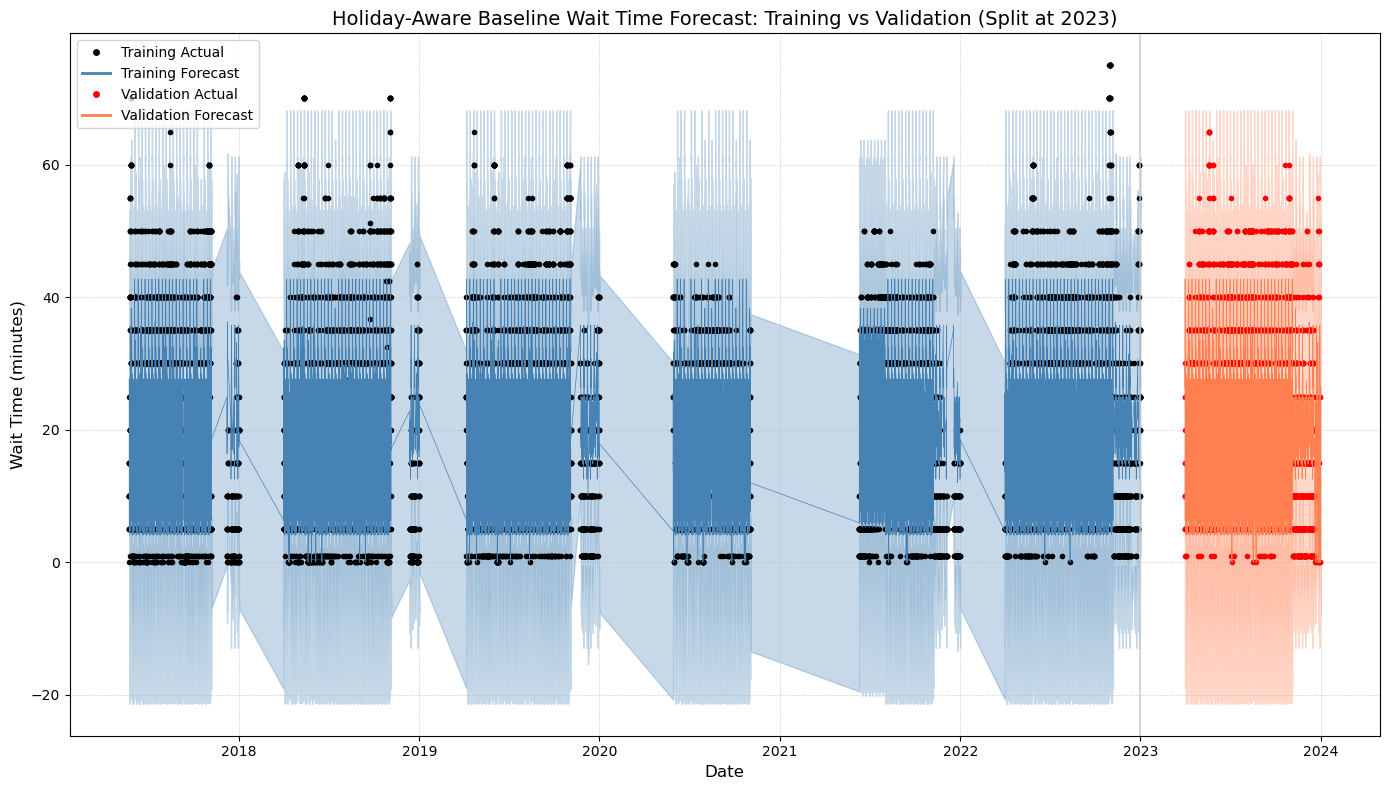


Holiday-Aware Baseline Model Evaluation:
MAE (Mean Absolute Error): 9.01 minutes
RMSE (Root-Mean-Square Deviation): 11.92 minutes
MAPE (Mean Absolute Percentage Error): 83.43%
Percentage of predictions within confidence interval: 95.20%


In [105]:
class HolidayAwareBaselineModel:
    """A model that uses different patterns for holidays and normal days."""
    def __init__(self):
        self.holiday_day_time_means = None
        self.normal_day_time_means = None
        self.holiday_time_means = None
        self.normal_time_means = None
        self.holiday_mean = None
        self.normal_mean = None
        self.global_mean = None
        
    def fit(self, train_data, holiday_data):
        """Fit separate models for holidays and normal days"""
        # Mark holiday days
        holiday_dates = set(pd.to_datetime(holiday_data['ds']).dt.date)
        train_data = train_data.copy()
        train_data['is_holiday'] = train_data['ds'].dt.date.isin(holiday_dates)
        
        # Create day-time keys if they don't exist yet
        if 'day_time_key' not in train_data.columns:
            train_data['day_time_key'] = (train_data['day_of_week'] * 24 * 60 + 
                                         train_data['time_key'])
        
        # Calculate means for holiday days
        holiday_data = train_data[train_data['is_holiday']]
        self.holiday_day_time_means = holiday_data.groupby('day_time_key')['y'].mean().to_dict()
        self.holiday_time_means = holiday_data.groupby('time_key')['y'].mean().to_dict()
        
        # Calculate means for normal days
        normal_data = train_data[~train_data['is_holiday']]
        self.normal_day_time_means = normal_data.groupby('day_time_key')['y'].mean().to_dict()
        self.normal_time_means = normal_data.groupby('time_key')['y'].mean().to_dict()
        
        # Global means as fallback
        self.holiday_mean = holiday_data['y'].mean() if len(holiday_data) > 0 else train_data['y'].mean()
        self.normal_mean = normal_data['y'].mean() if len(normal_data) > 0 else train_data['y'].mean()
        self.global_mean = train_data['y'].mean()
        self.std_dev = train_data['y'].std()
        
        return self
        
    def predict(self, future_df, holiday_data):
        """Predict using different models for holidays and normal days"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        
        # Extract day and time features
        predictions['day_of_week'] = predictions['ds'].dt.dayofweek
        predictions['hour'] = predictions['ds'].dt.hour
        predictions['minute'] = predictions['ds'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        predictions['day_time_key'] = (predictions['day_of_week'] * 24 * 60 + 
                                      predictions['time_key'])
        
        # Mark holiday days
        holiday_dates = set(pd.to_datetime(holiday_data['ds']).dt.date)
        predictions['is_holiday'] = predictions['ds'].dt.date.isin(holiday_dates)
        
        # Initialize predictions
        predictions['yhat'] = np.nan
        
        # Predict for holiday days
        holiday_mask = predictions['is_holiday']
        
        # First try day+time for holidays
        predictions.loc[holiday_mask, 'yhat'] = predictions.loc[holiday_mask, 'day_time_key'].map(
            lambda x: self.holiday_day_time_means.get(x, None))
        
        # Fall back to time of day for holidays
        still_na = holiday_mask & predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = predictions.loc[still_na, 'time_key'].map(
            lambda x: self.holiday_time_means.get(x, self.holiday_mean))
        
        # Predict for normal days
        normal_mask = ~predictions['is_holiday']
        
        # First try day+time for normal days
        predictions.loc[normal_mask, 'yhat'] = predictions.loc[normal_mask, 'day_time_key'].map(
            lambda x: self.normal_day_time_means.get(x, None))
        
        # Fall back to time of day for normal days
        still_na = normal_mask & predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = predictions.loc[still_na, 'time_key'].map(
            lambda x: self.normal_time_means.get(x, self.normal_mean))
        
        # Final fallback to global mean
        still_na = predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = self.global_mean
        
        # Confidence interval
        predictions['yhat_lower'] = predictions['yhat'] - 1.96 * self.std_dev
        predictions['yhat_upper'] = predictions['yhat'] + 1.96 * self.std_dev
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Train and evaluate the Holiday-Aware Baseline model
print("\n---- Training Holiday-Aware Baseline Model ----")
holiday_model = HolidayAwareBaselineModel()
holiday_model.fit(train_df, holidays_df)
holiday_forecast = holiday_model.predict(future, holidays_df)
holiday_forecast = post_process_forecast(holiday_forecast, baseline_df)
holiday_combined = combine_forecast_with_actual(holiday_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(holiday_combined, split_year=2023, show_uncertainty=True, 
                      model_name="Holiday-Aware Baseline")
plt.tight_layout()
plt.savefig("holiday_aware_baseline_forecast.png")
plt.show()

# Calculate error metrics
print("\nHoliday-Aware Baseline Model Evaluation:")
holiday_metrics = calculate_error_metrics(holiday_combined, val_df)

## Detailed Period Analysis

We'll examine specific time periods in detail to better understand model performance.

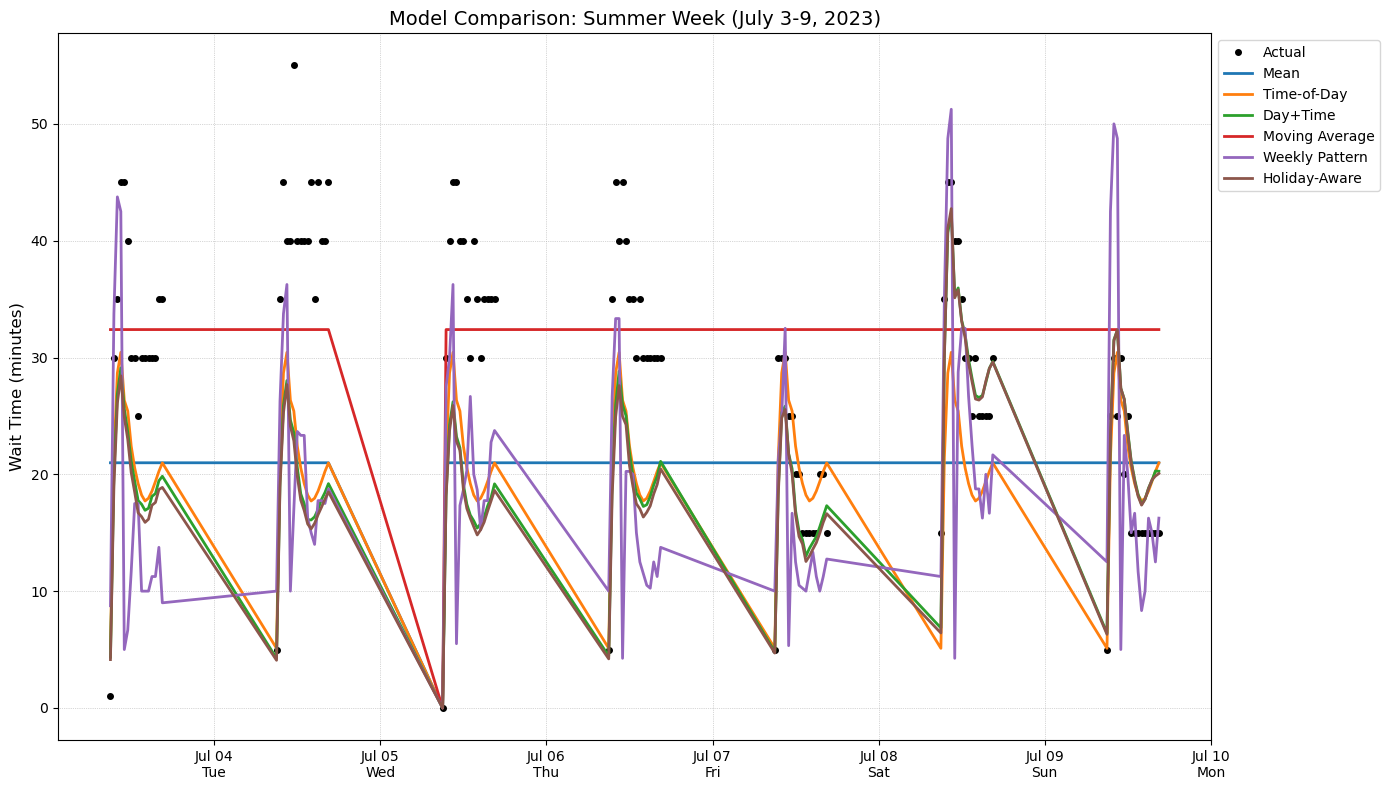

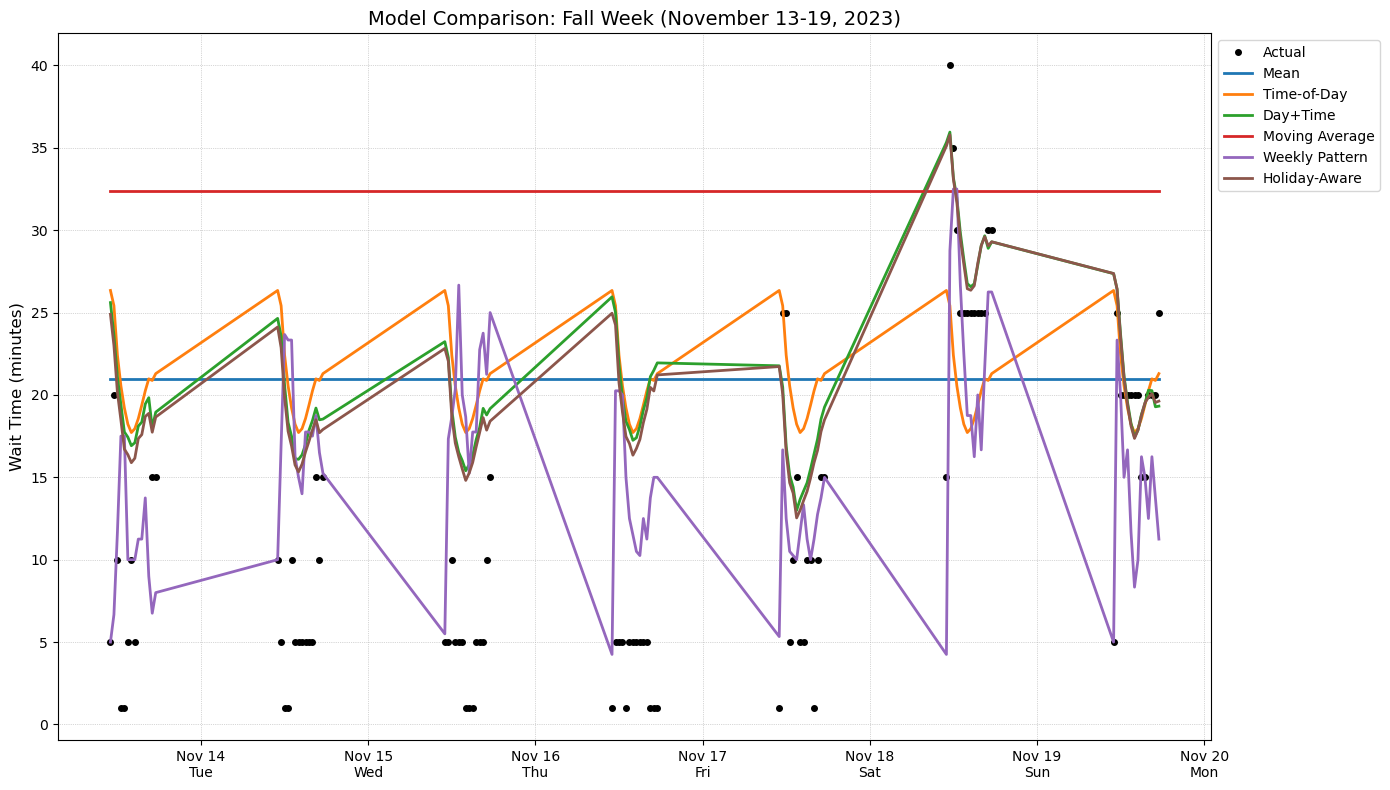

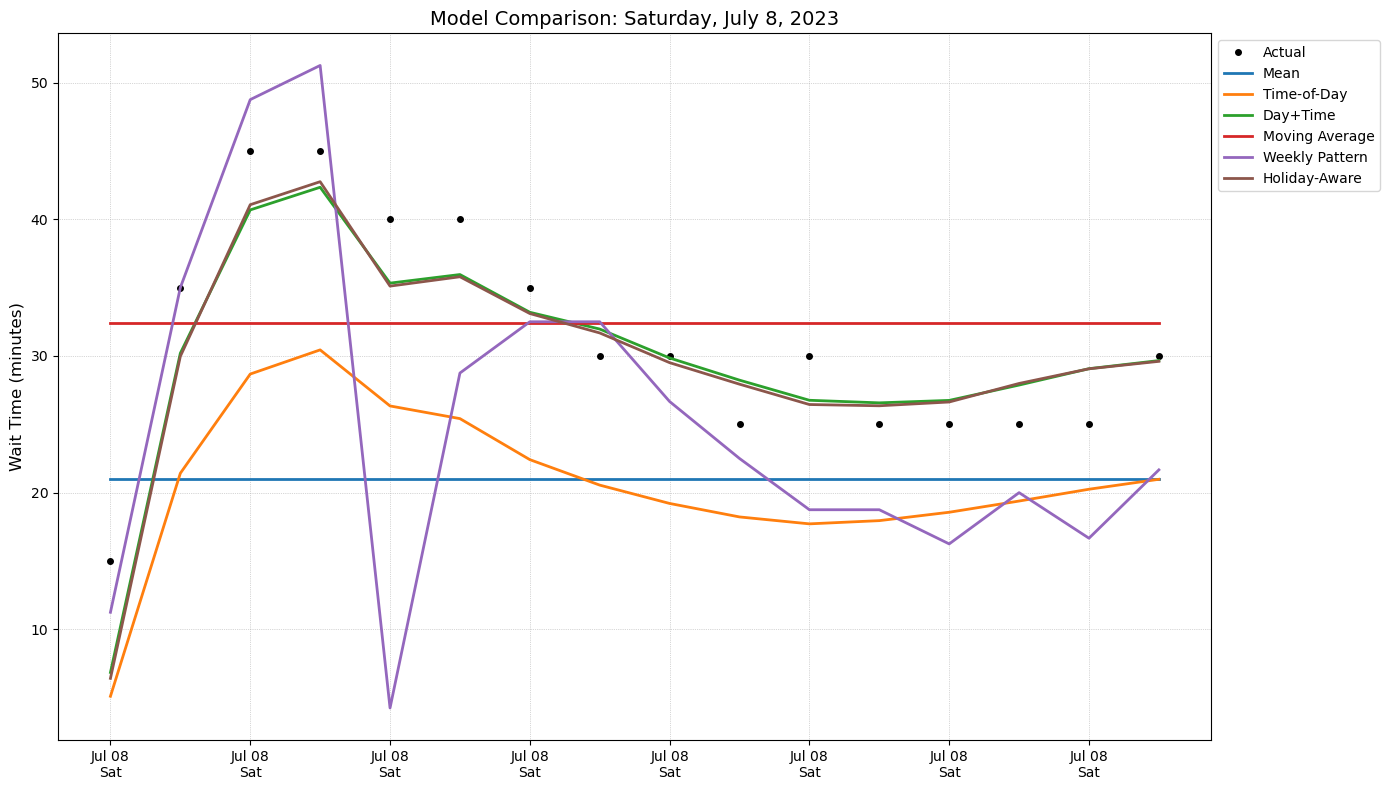

In [106]:
def plot_weekly_comparison(data_dict, start_date, end_date, title=None):
    """Plot forecasts from multiple models for a specified time period."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot actual values
    actual_data = list(data_dict.values())[0]
    ax.plot(actual_data.loc[start_date:end_date].index, 
            actual_data.loc[start_date:end_date].y, 
            'ko', markersize=4, label='Actual')
    
    # Plot each model's predictions
    for model_name, data in data_dict.items():
        ax.plot(data.loc[start_date:end_date].index, 
                data.loc[start_date:end_date].yhat, 
                lw=2, label=f'{model_name}')
    
    if title:
        ax.set_title(title, fontsize=14)
    else:
        ax.set_title(f'Model Comparison: {start_date} to {end_date}', fontsize=14)
    
    ax.set_ylabel('Wait Time (minutes)', fontsize=12)
    ax.grid(ls=':', lw=0.5)
    
    # Format x-axis to show dates nicely
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d\n%a'))
    
    # Add legend with smaller font outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    
    plt.tight_layout()
    return fig

# Create a dictionary with all model forecasts
model_forecasts = {
    'Mean': mean_combined,
    'Time-of-Day': tod_combined,
    'Day+Time': day_time_combined,
    'Moving Average': ma_combined,
    'Weekly Pattern': weekly_combined,
    'Holiday-Aware': holiday_combined
}

# Plot a summer week and a winter week
summer_fig = plot_weekly_comparison(model_forecasts, '2023-07-03', '2023-07-09', 
                                  title='Model Comparison: Summer Week (July 3-9, 2023)')
plt.savefig("baseline_summer_comparison.png", bbox_inches='tight')
plt.show()

winter_fig = plot_weekly_comparison(model_forecasts, '2023-11-13', '2023-11-19', 
                                  title='Model Comparison: Fall Week (November 13-19, 2023)')
plt.savefig("baseline_winter_comparison.png", bbox_inches='tight')
plt.show()

# Plot a single day in detail
day_fig = plot_weekly_comparison(model_forecasts, '2023-07-08', '2023-07-08', 
                               title='Model Comparison: Saturday, July 8, 2023')
plt.savefig("baseline_single_day_comparison.png", bbox_inches='tight')
plt.show()

## Model Comparison and Evaluation Summary

We'll compare all baseline models against each other.


---- Baseline Models Performance Comparison ----
                  Model       mae      rmse       mape  within_ci
 Holiday-Aware Baseline  9.009948 11.924748  83.426523  95.195985
      Day+Time Baseline  9.020490 11.938849  85.401687  95.315488
   Time-of-Day Baseline  9.918751 12.726130  94.819312  95.076482
          Mean Baseline 10.935506 13.635424 114.068993  28.130975
Weekly Pattern Baseline 11.211122 14.815550  83.472734  74.593690
Moving Average Baseline 14.731139 17.067505 190.595757  85.014340


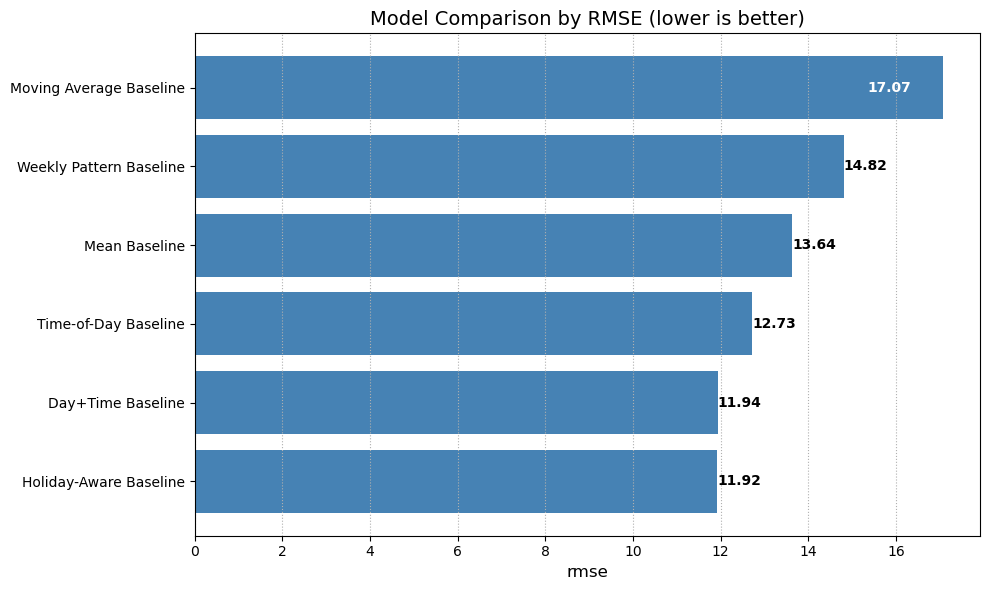

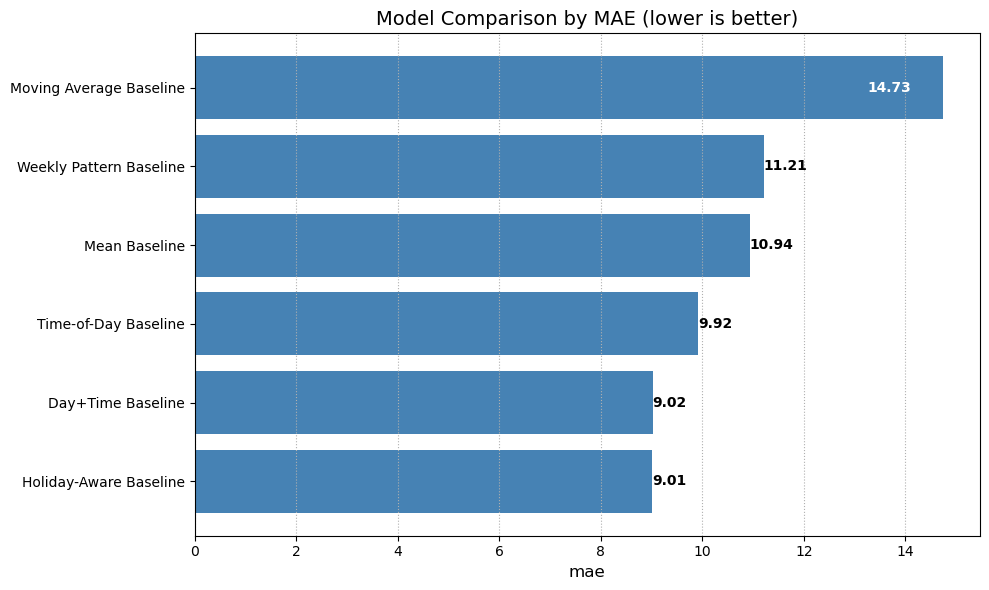

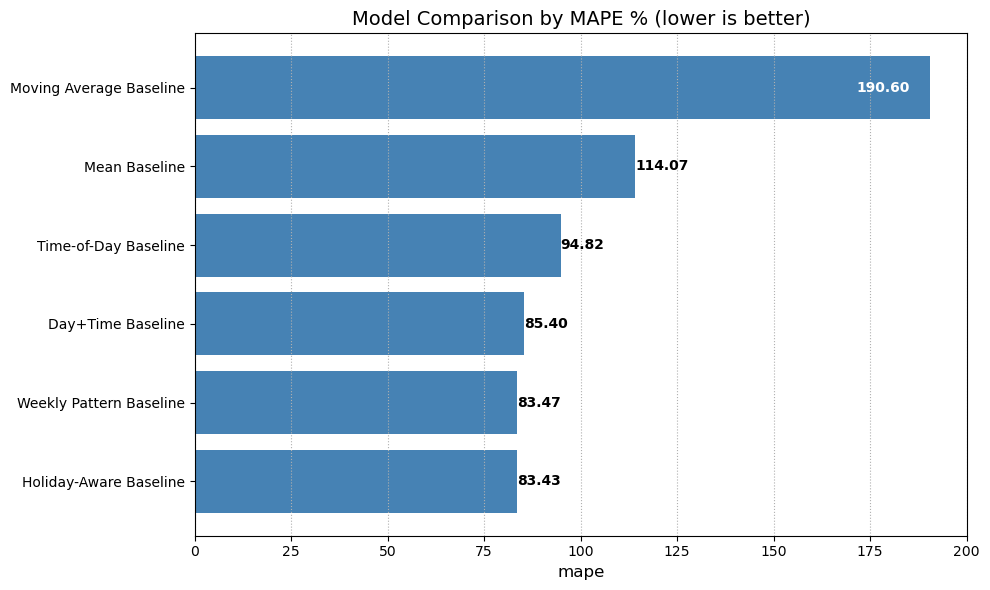

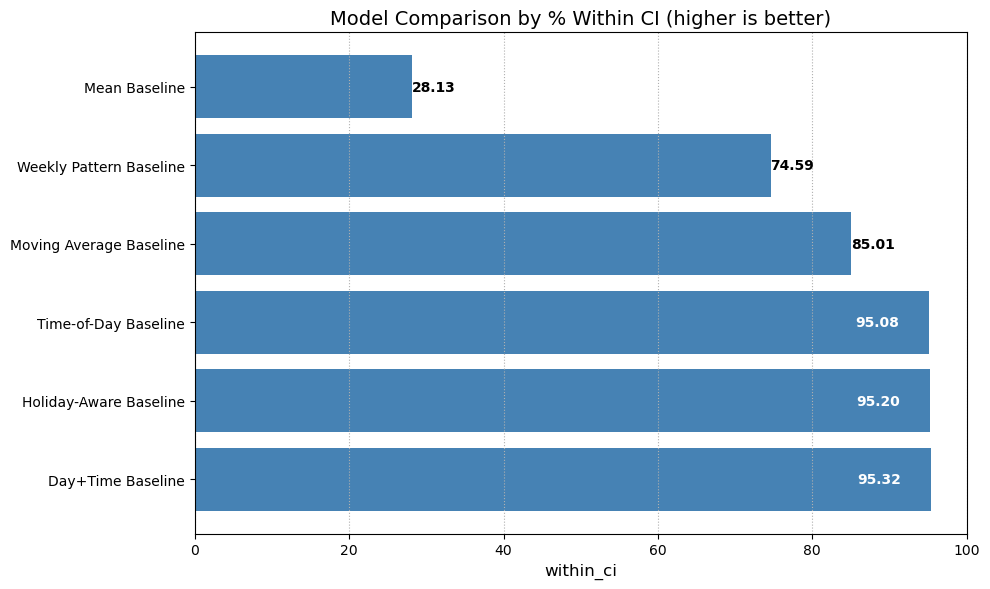

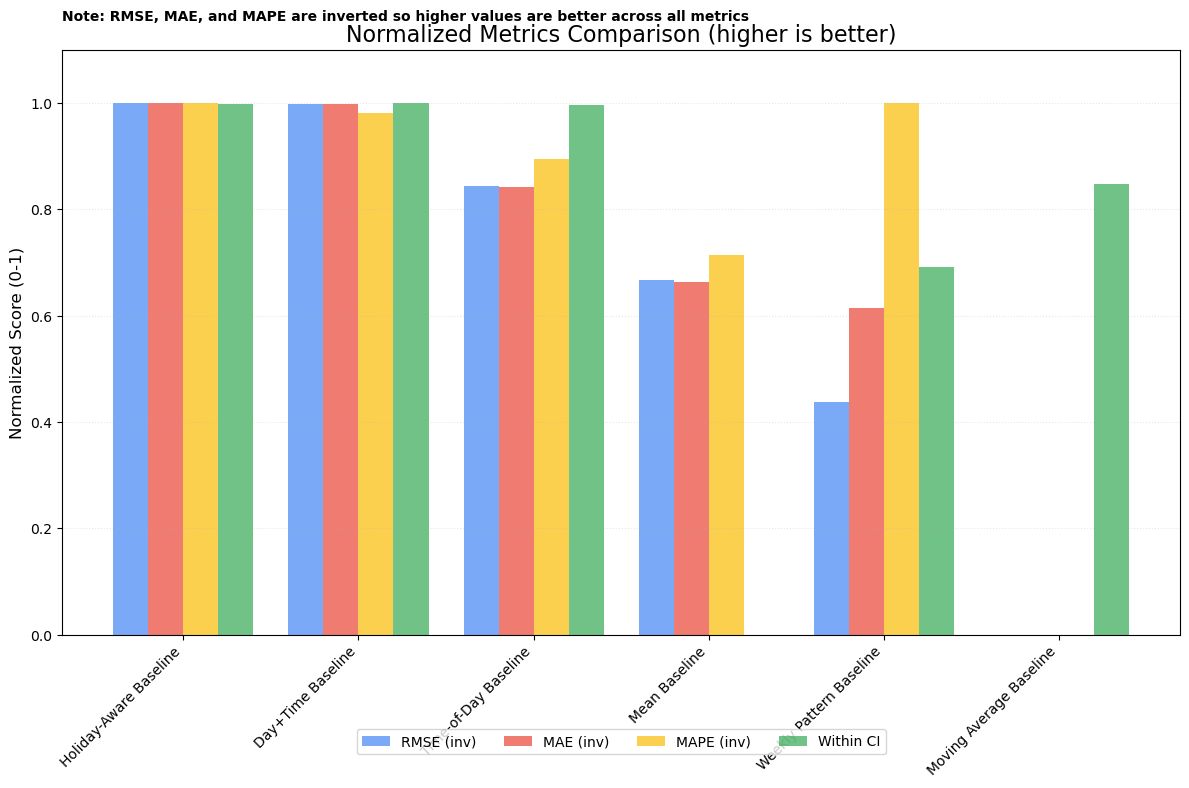


---- Conclusion ----
The best performing baseline model according to RMSE is: Holiday-Aware Baseline
This model achieved an RMSE of 11.92 minutes
The Prophet model can be compared against these baseline models to evaluate its effectiveness.


In [107]:
# Collect all evaluation metrics
all_metrics = {
    'Mean Baseline': mean_metrics,
    'Time-of-Day Baseline': tod_metrics,
    'Day+Time Baseline': day_time_metrics,
    'Moving Average Baseline': ma_metrics,
    'Weekly Pattern Baseline': weekly_metrics,
    'Holiday-Aware Baseline': holiday_metrics
}

# Create a DataFrame for easy comparison
metrics_df = pd.DataFrame.from_dict(all_metrics, orient='index')
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model'})

# Sort by RMSE (ascending)
metrics_df = metrics_df.sort_values('rmse')

# Print table
print("\n---- Baseline Models Performance Comparison ----")
print(metrics_df.to_string(index=False))

# Create a visual comparison of metrics
def plot_metric_comparison(metrics_df, metric_name, title=None, lower_is_better=True):
    """Plot a comparison of a specific metric across models."""
    # Sort by the metric
    if lower_is_better:
        df = metrics_df.sort_values(metric_name)
    else:
        df = metrics_df.sort_values(metric_name, ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bar plot
    bars = ax.barh(df['Model'], df[metric_name], color=TRAIN_COLOR)
    
    # Add value labels to the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width if width < max(df[metric_name]) * 0.9 else width * 0.9
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', va='center', 
                color='white' if width >= max(df[metric_name]) * 0.9 else 'black',
                fontweight='bold')
    
    if title:
        ax.set_title(title, fontsize=14)
    else:
        direction = "lower is better" if lower_is_better else "higher is better"
        ax.set_title(f'Model Comparison by {metric_name} ({direction})', fontsize=14)
    
    ax.set_xlabel(metric_name, fontsize=12)
    ax.grid(axis='x', linestyle=':')
    
    plt.tight_layout()
    return fig

# Plot each metric
rmse_fig = plot_metric_comparison(metrics_df, 'rmse', 'Model Comparison by RMSE (lower is better)')
plt.savefig("baseline_rmse_comparison.png")
plt.show()

mae_fig = plot_metric_comparison(metrics_df, 'mae', 'Model Comparison by MAE (lower is better)')
plt.savefig("baseline_mae_comparison.png")
plt.show()

mape_fig = plot_metric_comparison(metrics_df, 'mape', 'Model Comparison by MAPE % (lower is better)')
plt.savefig("baseline_mape_comparison.png")
plt.show()

within_ci_fig = plot_metric_comparison(metrics_df, 'within_ci', 
                                    'Model Comparison by % Within CI (higher is better)', 
                                    lower_is_better=False)
plt.savefig("baseline_within_ci_comparison.png")
plt.show()

# Create a summary plot with all metrics
def plot_all_metrics(metrics_df):
    """Create a comprehensive comparison of all metrics across models."""
    # Normalize metrics for comparison (0-1 scale)
    normalized_df = metrics_df.copy()
    
    # For metrics where lower is better (rmse, mae, mape)
    for metric in ['rmse', 'mae', 'mape']:
        max_val = normalized_df[metric].max()
        min_val = normalized_df[metric].min()
        if max_val > min_val:  # Avoid division by zero
            normalized_df[f'{metric}_norm'] = 1 - (normalized_df[metric] - min_val) / (max_val - min_val)
        else:
            normalized_df[f'{metric}_norm'] = 1
    
    # For within_ci where higher is better
    max_val = normalized_df['within_ci'].max()
    min_val = normalized_df['within_ci'].min()
    if max_val > min_val:  # Avoid division by zero
        normalized_df['within_ci_norm'] = (normalized_df['within_ci'] - min_val) / (max_val - min_val)
    else:
        normalized_df['within_ci_norm'] = 1
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define metrics for the plot
    metrics_to_plot = ['rmse_norm', 'mae_norm', 'mape_norm', 'within_ci_norm']
    metric_labels = ['RMSE (inv)', 'MAE (inv)', 'MAPE (inv)', 'Within CI']
    colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853']  # Google-like colors
    width = 0.2  # Width of each bar
    
    # Create positions for bars
    models = normalized_df['Model']
    x = np.arange(len(models))
    
    # Plot bars for each metric
    for i, (metric, label, color) in enumerate(zip(metrics_to_plot, metric_labels, colors)):
        ax.bar(x + i*width - 0.3, normalized_df[metric], width, label=label, color=color, alpha=0.7)
    
    # Add labels and legend
    ax.set_title('Normalized Metrics Comparison (higher is better)', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(metrics_to_plot))
    
    # Add grid and labels
    ax.set_ylabel('Normalized Score (0-1)', fontsize=12)
    ax.set_ylim(0, 1.1)  # Leave room for labels
    ax.grid(axis='y', linestyle=':', alpha=0.3)
    
    # Add a note about the normalization
    ax.text(0, 1.05, 'Note: RMSE, MAE, and MAPE are inverted so higher values are better across all metrics',
            transform=ax.transAxes, fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    return fig

# Create the comprehensive metric comparison
all_metrics_fig = plot_all_metrics(metrics_df)
plt.savefig("baseline_all_metrics_comparison.png", bbox_inches='tight')
plt.show()

# Print conclusion
print("\n---- Conclusion ----")
best_model = metrics_df.iloc[0]['Model']
print(f"The best performing baseline model according to RMSE is: {best_model}")
print(f"This model achieved an RMSE of {metrics_df.iloc[0]['rmse']:.2f} minutes")
print(f"The Prophet model can be compared against these baseline models to evaluate its effectiveness.")

## Baseline Model: LastWeek Model

This model predicts wait times by using the exact value from the same day and time in the previous week. It's a simple but effective model for capturing weekly seasonality.


---- Training Robust LastWeek Model ----

Match type analysis:
day_hour_match: 26288 (100.0%)


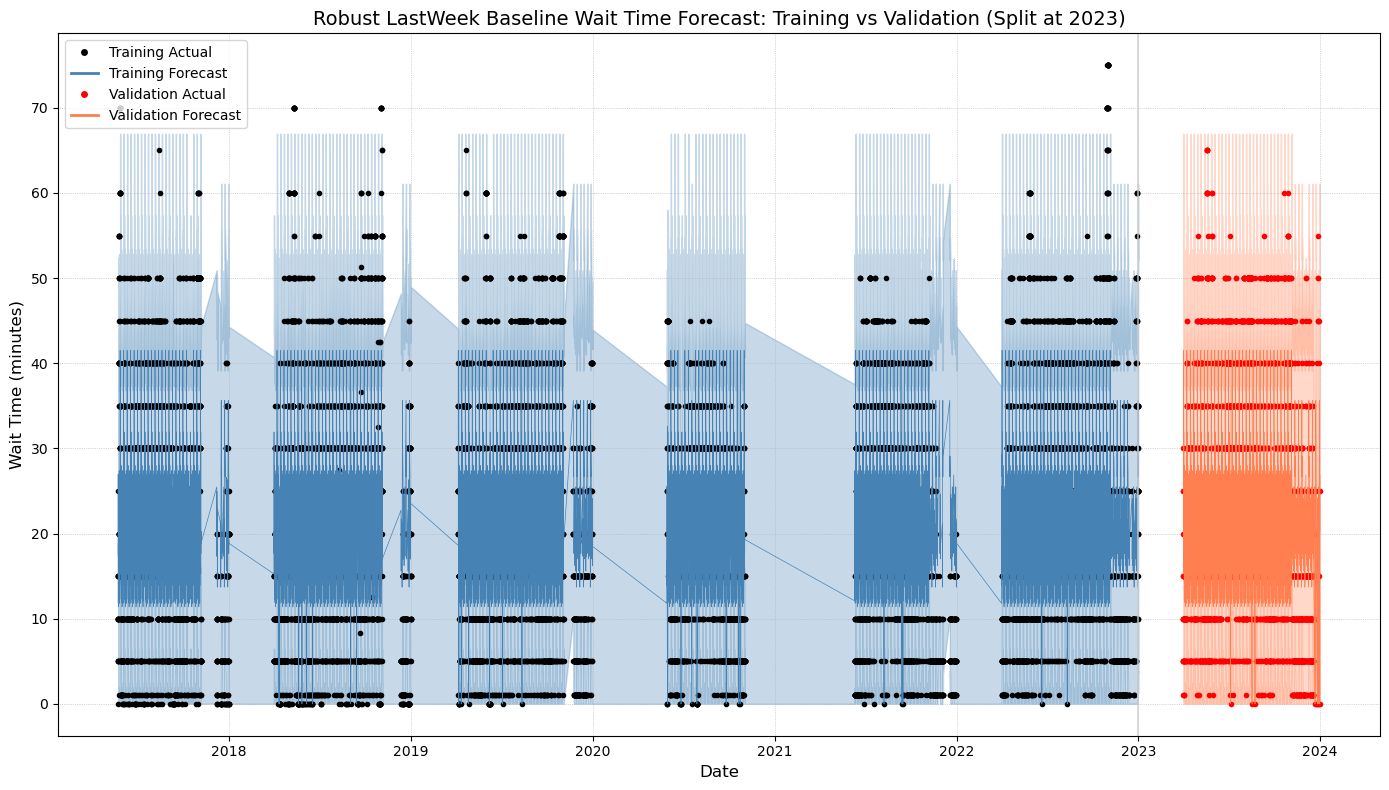


Robust LastWeek Baseline Evaluation:
MAE (Mean Absolute Error): 9.42 minutes
RMSE (Root-Mean-Square Deviation): 12.25 minutes
MAPE (Mean Absolute Percentage Error): 92.38%
Percentage of predictions within confidence interval: 95.03%


In [119]:
# ## Robust LastWeek Baseline Model
# 
# This model finds the most similar day/time from previous weeks
# rather than requiring exact timestamp matches.

class RobustLastWeekModel:
    """A baseline that uses data from the same day of week and hour from recent weeks."""
    def __init__(self):
        self.training_data = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store the training data for later prediction"""
        self.training_data = train_data.copy().reset_index(drop=True)
        self.std_dev = self.training_data['y'].std()
        self.global_mean = self.training_data['y'].mean()
        
        # Pre-calculate features
        self.training_data['day_of_week'] = self.training_data['ds'].dt.dayofweek
        self.training_data['hour'] = self.training_data['ds'].dt.hour
        
        # Create lookup tables for faster matching
        self.day_hour_means = {}
        for day in range(7):  # 0-6 for Monday-Sunday
            for hour in range(24):  # 0-23 hours
                matches = self.training_data[
                    (self.training_data['day_of_week'] == day) &
                    (self.training_data['hour'] == hour)
                ]
                if len(matches) > 0:
                    self.day_hour_means[(day, hour)] = matches['y'].mean()
        
        return self
        
    def predict(self, future_df):
        """Predict using day of week and hour patterns from training data"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        
        # Extract features
        predictions['day_of_week'] = predictions['ds'].dt.dayofweek
        predictions['hour'] = predictions['ds'].dt.hour
        
        # Make predictions
        yhat = []
        match_types = []
        
        for _, row in predictions.iterrows():
            day = row['day_of_week']
            hour = row['hour']
            
            # Find all matching instances of same day/hour from training
            key = (day, hour)
            if key in self.day_hour_means:
                # Use average of all matching times from training
                pred_value = self.day_hour_means[key]
                match_types.append(f"day_hour_match")
            else:
                # Fallback to global mean
                pred_value = self.global_mean
                match_types.append("global_mean")
                
            yhat.append(pred_value)
        
        # Add predictions to dataframe
        predictions['yhat'] = yhat
        predictions['yhat_lower'] = [max(0, y - 1.96 * self.std_dev) for y in yhat]
        predictions['yhat_upper'] = [y + 1.96 * self.std_dev for y in yhat]
        
        # Print match statistics
        match_counts = pd.Series(match_types).value_counts()
        print("\nMatch type analysis:")
        for match_type, count in match_counts.items():
            print(f"{match_type}: {count} ({count/len(match_types)*100:.1f}%)")
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Create future dataframe for predictions
future = pd.DataFrame({'ds': pd.concat([train_df['ds'], val_df['ds']]).unique()})
future = future.sort_values('ds').reset_index(drop=True)

# Train and evaluate the Robust LastWeek model
print("\n---- Training Robust LastWeek Model ----")
lastweek_model = RobustLastWeekModel()
lastweek_model.fit(train_df)
lastweek_forecast = lastweek_model.predict(future)
lastweek_forecast = post_process_forecast(lastweek_forecast, baseline_df)
lastweek_combined = combine_forecast_with_actual(lastweek_forecast, train_df, val_df)

# Plot results using the standard plotting function
plot_forecast_comparison(lastweek_combined, split_year=2023, show_uncertainty=True, 
                       model_name="Robust LastWeek Baseline")
plt.tight_layout()
plt.savefig("robust_lastweek_baseline_forecast.png")
plt.show()

# Calculate error metrics
print("\nRobust LastWeek Baseline Evaluation:")
lastweek_metrics = calculate_error_metrics(lastweek_combined, val_df)

## True Last Week Persistence Model

This model predicts the exact value from 7 days ago, but handles training and validation sets separately. It only uses training data to predict training points, and only validation data to predict validation points.



---- Training Improved LastWeek Model ----


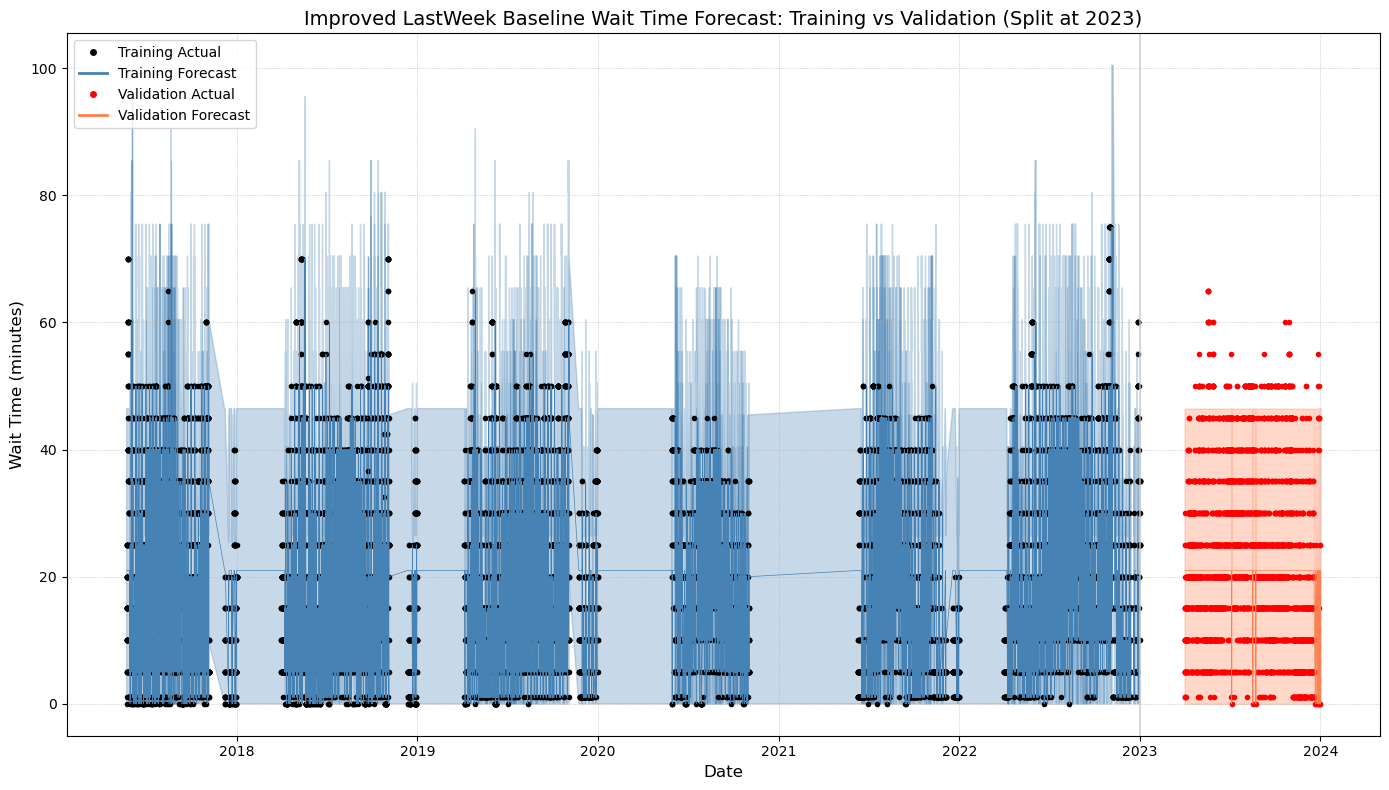


Improved LastWeek Baseline Evaluation:
MAE (Mean Absolute Error): 10.94 minutes
RMSE (Root-Mean-Square Deviation): 13.64 minutes
MAPE (Mean Absolute Percentage Error): 114.07%
Percentage of predictions within confidence interval: 95.17%


In [ ]:
class TrueLastWeekModel:
    """A model that uses the exact value from 7 days before in the same dataset."""
    def __init__(self):
        self.train_data = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store training data"""
        self.train_data = train_data.copy().reset_index(drop=True)
        self.train_data_dict = dict(zip(self.train_data['ds'], self.train_data['y']))
        self.std_dev = self.train_data['y'].std()
        self.global_mean = self.train_data['y'].mean()
        return self
        
    def predict(self, future_df, val_data=None):
        """Predict using values from 7 days before in the same dataset"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        yhat = []
        
        # Create value lookup dictionaries
        if val_data is not None:
            val_data = val_data.copy().reset_index(drop=True)
            val_data_dict = dict(zip(val_data['ds'], val_data['y']))
        
        # For each prediction date
        for date in predictions['ds']:
            last_week = date - pd.Timedelta(days=7)
            
            # For validation dates, first check in validation data
            if val_data is not None and date in val_data['ds'].values:
                if last_week in val_data_dict:
                    yhat.append(val_data_dict[last_week])
                else:
                    # If no exact match, use global mean
                    yhat.append(self.global_mean)
            # For training dates, check in training data
            else:
                if last_week in self.train_data_dict:
                    yhat.append(self.train_data_dict[last_week])
                else:
                    # If no exact match, use global mean
                    yhat.append(self.global_mean)
        
        # Add predictions and confidence intervals
        predictions['yhat'] = yhat
        predictions['yhat_lower'] = [max(0, y - 1.96 * self.std_dev) for y in yhat]
        predictions['yhat_upper'] = [y + 1.96 * self.std_dev for y in yhat]
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Create future dataframe for predictions
future = pd.DataFrame({'ds': pd.concat([train_df['ds'], val_df['ds']]).unique()})
future = future.sort_values('ds').reset_index(drop=True)

# Train and evaluate the True Last Week model
print("\n---- Training True Last Week Persistence Model ----")
lastweek_model = TrueLastWeekModel()
lastweek_model.fit(train_df)

# This time, pass both future dataframe and validation data
lastweek_forecast = lastweek_model.predict(future, val_df)
lastweek_forecast = post_process_forecast(lastweek_forecast, baseline_df)
lastweek_combined = combine_forecast_with_actual(lastweek_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(lastweek_combined, split_year=2023, show_uncertainty=True, 
                       model_name="True Last Week Persistence")
plt.tight_layout()
plt.savefig("true_lastweek_persistence_forecast.png")
plt.show()

# Calculate error metrics
print("\nTrue Last Week Persistence Model Evaluation:")
lastweek_metrics = calculate_error_metrics(lastweek_combined, val_df)

## LastYear Baseline Model

This model predicts the wait time from exactly 365 days ago. It uses annual persistence rather than weekly persistence.


---- Training LastYear Model ----


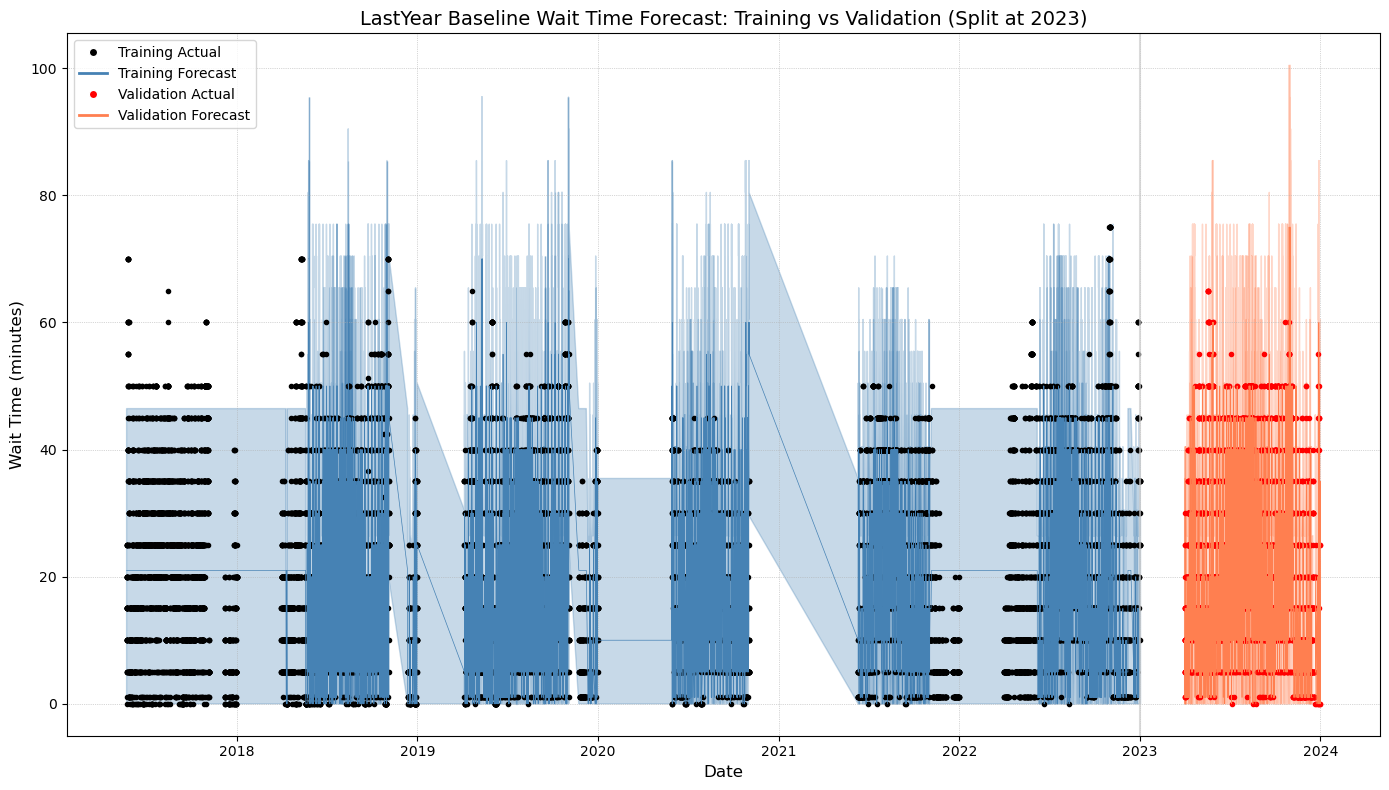


LastYear Baseline Evaluation:
MAE (Mean Absolute Error): 11.45 minutes
RMSE (Root-Mean-Square Deviation): 15.65 minutes
MAPE (Mean Absolute Percentage Error): 69.19%
Percentage of predictions within confidence interval: 88.00%


In [116]:
class LastYearModel:
    """A baseline that uses the exact value from 365 days ago."""
    def __init__(self):
        self.historical_data = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store the training data indexed by timestamp"""
        self.historical_data = train_data.copy().reset_index(drop=True)
        # Create a lookup dictionary for fast access
        self.date_to_value = dict(zip(self.historical_data['ds'], self.historical_data['y']))
        self.std_dev = self.historical_data['y'].std()
        self.global_mean = self.historical_data['y'].mean()
        return self
        
    def predict(self, future_df):
        """Predict using the exact same wait time from 365 days ago"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        yhat = []
        
        for date in predictions['ds']:
            # Simply look up the value from 365 days ago
            last_year = date - pd.Timedelta(days=365)
            
            # If we have data for that exact date, use it
            if last_year in self.date_to_value:
                yhat.append(self.date_to_value[last_year])
            else:
                # Look for closest date within a 3-day window
                closest_date = None
                min_diff = pd.Timedelta(days=3)
                
                for historical_date in self.date_to_value.keys():
                    diff = abs(historical_date - last_year)
                    if diff < min_diff:
                        min_diff = diff
                        closest_date = historical_date
                
                if closest_date is not None:
                    yhat.append(self.date_to_value[closest_date])
                else:
                    # Otherwise use global mean
                    yhat.append(self.global_mean)
                
        predictions['yhat'] = yhat
        predictions['yhat_lower'] = [max(0, y - 1.96 * self.std_dev) for y in yhat]
        predictions['yhat_upper'] = [y + 1.96 * self.std_dev for y in yhat]
        
        return predictions

# Train and evaluate the LastYear model
print("\n---- Training LastYear Model ----")
lastyear_model = LastYearModel()
lastyear_model.fit(train_df)
lastyear_forecast = lastyear_model.predict(future)
lastyear_forecast = post_process_forecast(lastyear_forecast, baseline_df)
lastyear_combined = combine_forecast_with_actual(lastyear_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(lastyear_combined, split_year=2023, show_uncertainty=True, 
                       model_name="LastYear Baseline")
plt.tight_layout()
plt.savefig("lastyear_baseline_forecast.png")
plt.show()

# Calculate error metrics
print("\nLastYear Baseline Evaluation:")
lastyear_metrics = calculate_error_metrics(lastyear_combined, val_df)